In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMeAnalysis/python_analysis/analysisTools")
import plotTools as ptools
import mplhep

In [2]:
f_sig = "signal_v2_2018_aEM_ejdR_rejection_IDcut.coffea"
sig = util.load(f_sig)[0]

bkg_files = {
    #"QCD":"bkg_2018_QCD_TuneCP5_PSWeights_ejdR_rejection_IDcut.coffea", QCD doesn't make it to cut 13 here!
    "Top":"bkg_2018_Top_ejdR_rejection_IDcut.coffea",
    "DY":"bkg_2018_DY_ejdR_rejection_IDcut.coffea",
    "Diboson":"bkg_2018_Diboson_ejdR_rejection_IDcut.coffea",
    "Triboson":"bkg_2018_Triboson_ejdR_rejection_IDcut.coffea",
    "W+jets":"bkg_2018_WJets_ejdR_rejection_IDcut.coffea",
    "Z+jets":"bkg_2018_ZJets_ejdR_rejection_IDcut.coffea"
}
bkg_histos = {}
for b in bkg_files.keys():
    bkg_histos[b] = util.load(bkg_files[b])[0]
    histograms = list(bkg_histos[b].keys())
all_bkgs = list(bkg_histos.keys())
bkg = {}
for h in histograms:
    if type(bkg_histos['Top'][h]) != hist.Hist:
        continue
    hists = []
    for b in all_bkgs:
        hists.append(bkg_histos[b][h])
    bkg[h] = sum(hists)[{"samp":sum}]

In [5]:
from matplotlib.colors import LogNorm
def plot_SoverB(samp,hname,rebinx,rebiny,cut="cut7",forwardX=True,forwardY=True,xlabel="",ylabel="",m="",dm="",ct="",xlim=None,ylim=None):
    hb = bkg[hname][{"cut":cut}][::rebinx,::rebiny]
    x = hb.axes[0].edges[:-1]
    y = hb.axes[1].edges[:-1]
    ratios = {}
    hs = sig[hname][{"samp":samp,"cut":cut}][::rebinx,::rebiny]
    num = np.zeros((len(x),len(y)))
    den = np.zeros((len(x),len(y)))
    for i,xi in enumerate(x):
        for j,yj in enumerate(y):
            sliceX = slice(i,hist.overflow+1,sum) if forwardX else slice(hist.underflow,i+1,sum)
            sliceY = slice(j,hist.overflow+1,sum) if forwardY else slice(hist.underflow,j+1,sum)
            num[i,j] = hs[sliceX,sliceY].value
            den[i,j] = hb[sliceX,sliceY].value
    ratio = np.divide(num,np.sqrt(den),where=den>0)
    ratio[(num>0)&(den==0)] = np.inf
    ratio[(num==0)&(den==0)] = 0
    vmax = np.max(ratio[ratio!=np.inf])
    vmin = np.min(ratio[ratio>0])
    
    plt.figure(figsize=(5,5))
    from matplotlib.colors import LogNorm
    norm = LogNorm(vmin=vmin,vmax=vmax)
    ratio[ratio==np.inf] = vmax
    #plt.title(samp,fontsize=14)
    plt.imshow(ratio.T,extent=[x[0],x[-1],y[0],y[-1]],aspect='auto',origin='lower',norm=norm,cmap='plasma')
    xlabel_mod = xlabel+", forward" if forwardX else xlabel+", backward"
    ylabel_mod = ylabel+", forward" if forwardY else ylabel+", backward"
    plt.xlabel(xlabel_mod,fontsize=14)
    plt.ylabel(ylabel_mod,fontsize=14)
    plt.colorbar()
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    #plt.title(r"$\Delta$ = {0:.1f}, $m$ = {1}, $c\tau$ = {2}".format(dm,int(m),int(ct)),fontsize=16)
    plt.tight_layout()
    #if not os.path.exists(f"plots/ABCD/{cut}/{hname}/{samp}"):
    #    os.makedirs(f"plots/ABCD/{cut}/{hname}/{samp}")
    xtitle = "forwardX" if forwardX else "backwardX"
    ytitle = "forwardY" if forwardY else "backwardY"
    #plt.savefig(f"plots/ABCD/{cut}/{hname}/{samp}/significance_{samp}_{xtitle}_{ytitle}.png")
    #plt.close()
    
def integrate(h,xlim,ylim,forwardX=True,forwardY=True):
    ex = h.axes[0].edges
    ey = h.axes[1].edges
    i = np.digitize(xlim,ex)-1
    j = np.digitize(ylim,ey)-1
    sliceX = slice(i,hist.overflow+1,sum) if forwardX else slice(hist.underflow,i+1,sum)
    sliceY = slice(j,hist.overflow+1,sum) if forwardY else slice(hist.underflow,j+1,sum)
    
    return h[sliceX,sliceY].value

In [4]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
all_ctaus = sorted(list(set(si.ctau)))

In [64]:
hname = "sel_vtx_METdPhi_vs_mindxy"
xlim = 0.5
forwardX = False
ylim = 0.03
forwardY = True

# scaling up from 2018 lumi to full 16-18 lumi
nb = (139/59.843)*integrate(bkg['sel_vtx_METdPhi_vs_mindxy'][{'cut':'cut11'}],xlim,ylim,forwardX=forwardX,forwardY=forwardY)
ns = {}
for delta in deltas:
    m1s = sorted(list(set(si[si.delta==delta].m1)))
    for m1 in m1s:
        ctaus = sorted(list(set(si[(si.delta==delta)&(si.m1==m1)].ctau)))
        for ct in ctaus:
            point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
            hs = sig[hname][{'samp':point,'cut':'cut11'}]
            sig_yield = (139/59.843)*integrate(hs,xlim,ylim,forwardX=forwardX,forwardY=forwardY)
            ns[f"{delta}-{m1}-{ct}"] = sig_yield

In [65]:
base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe/"
for pt in ns.keys():
    with open(base+"card.txt","r") as f:
        template = f.read()
    data = template.replace("NSIG",f"{ns[pt]:.3f}")
    data = data.replace("NBKG",f"{nb:.3f}")
    data = data.replace("NOBS",f"{nb:.3f}")
    delta,m1,ct = pt.split('-')
    delta = float(delta)
    m1 = float(m1)
    ct = float(ct)
    name = f"delta{delta:.1f}_m{m1:.1f}_ct{ct:.1f}_dPhiCut{xlim:.1f}_dxyCut{ylim:.2f}".replace(".","p")
    with open(base+f"{name}_card.txt","w") as f:
        f.write(data)

In [66]:
import os
import uproot
import pandas as pd
xs = pd.read_csv('/uscms/home/sbrightt/nobackup/iDMe/signal_xsec/MG5_aMC_v2_9_6/bin/signal_xsec_table.csv')
xs = xs[xs.alphaD=="aEM"]
xs['m1'] = xs.Mchi - xs.dMchi/2
xs['delta'] = xs.dMchi/xs.m1

cut_setting = f"dPhiCut{xlim:.1f}_dxyCut{ylim:.2f}".replace(".","p")
root_files = [f for f in os.listdir(base) if '.root' in f and cut_setting in f]
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
xsecs = []
for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct,xcut,ycut = point.split("_")
    delta = float(delta[5:].replace("p","."))
    m1 = float(m1[1:].replace("p","."))
    ct = float(ct[2:].replace("p","."))
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ct==ct)]['xsec(pb)'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])
lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "xsec":xsecs
})

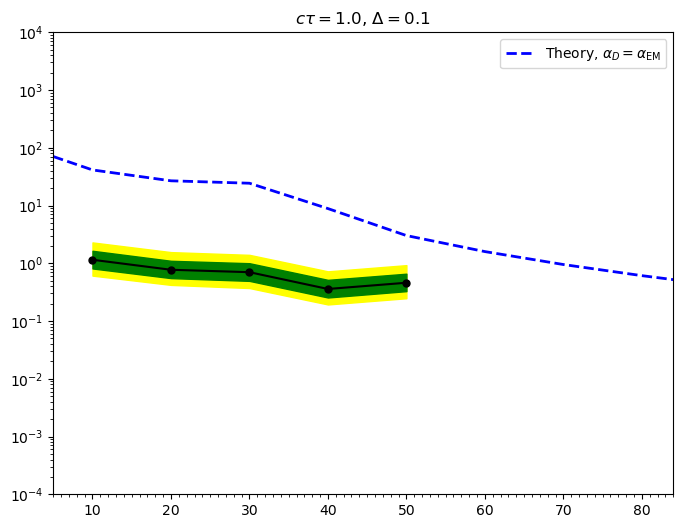

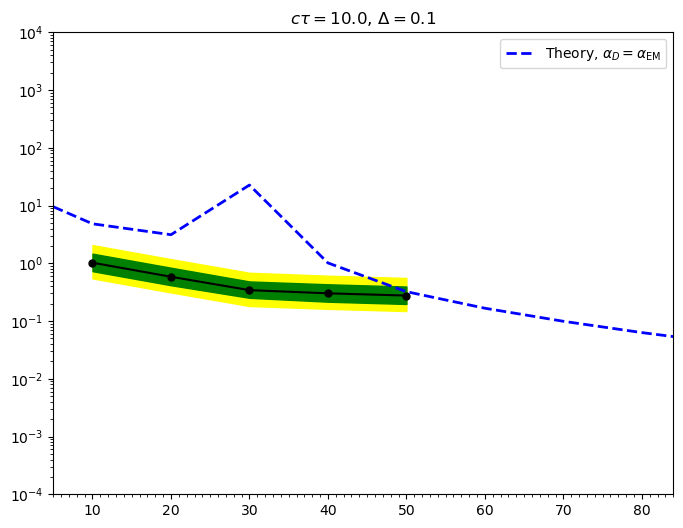

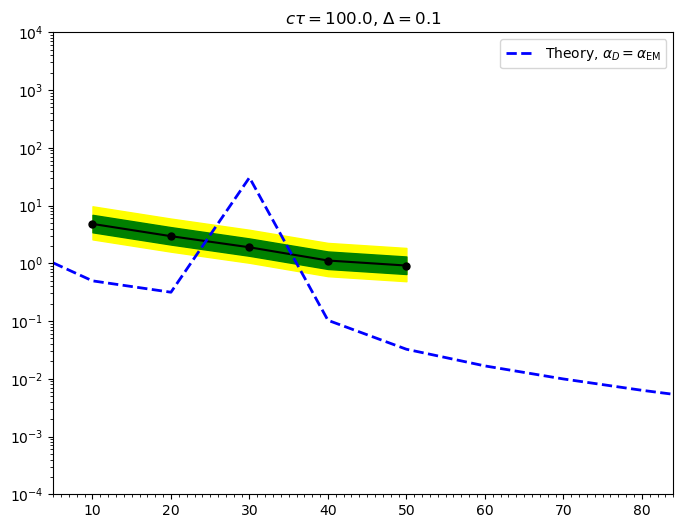

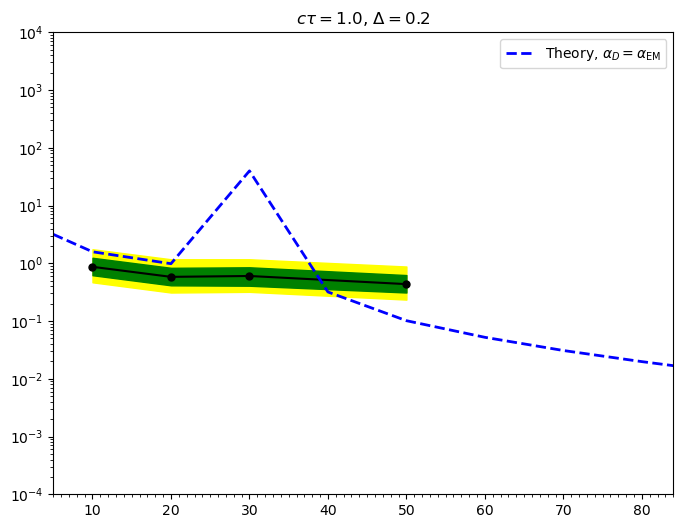

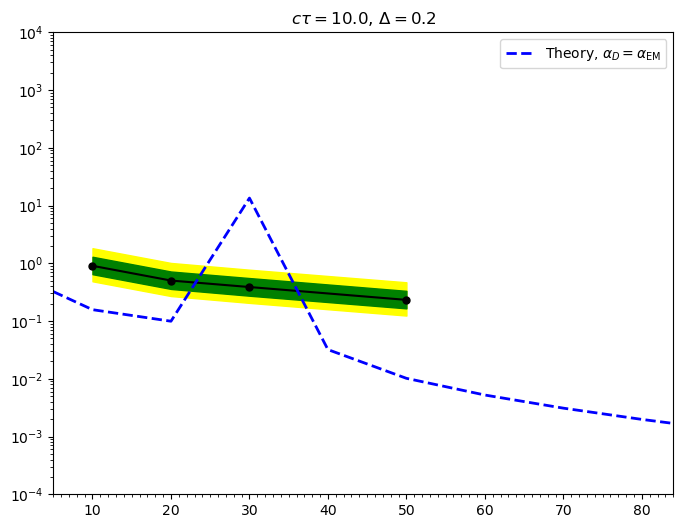

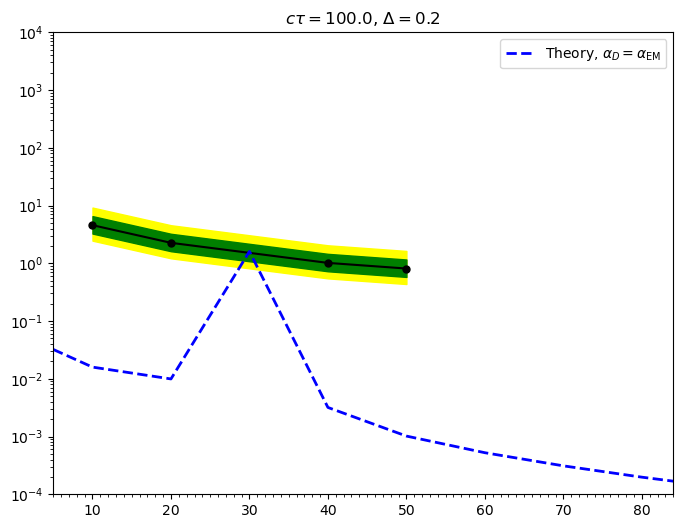

In [68]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

deltas = sorted(list(set(lims.delta)))
all_ctaus = sorted(list(set(lims.ct)))
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        theory_xsec = xs[(xs.delta==d)&(xs.ct==ct)]["xsec(pb)"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ct==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        for m1 in mass1s:
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            noms.append(r*xsec)
            m1s.append(rm1*xsec)
            p1s.append(rp1*xsec)
            m2s.append(rm2*xsec)
            p2s.append(rp2*xsec)
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.fill_between(mass1s,m2s,p2s,color="yellow")
        plt.fill_between(mass1s,m1s,p1s,color="green")
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10)
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([5,84])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        plt.savefig(f"plots/expected_lims/delta{d}_ct{ct}_{cut_setting}.pdf")

In [36]:
theory_m1

array([  5.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

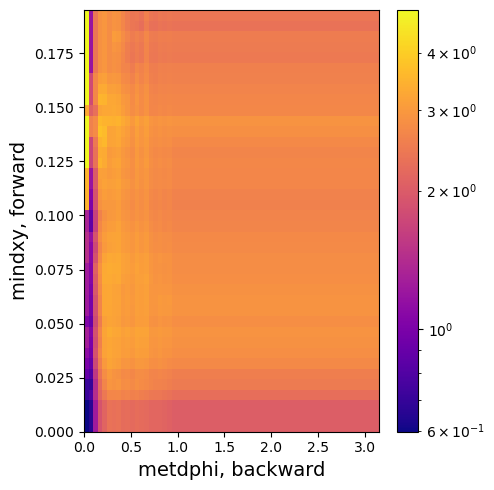

In [13]:
plot_SoverB("sig_2018_Mchi-52p5_dMchi-5p0_ctau-10",
            "sel_vtx_METdPhi_vs_mindxy",
            1j,1j,cut="cut11",forwardX=False,forwardY=True,xlabel="metdphi",ylabel="mindxy",m="",dm="",ct="",xlim=None,ylim=None)

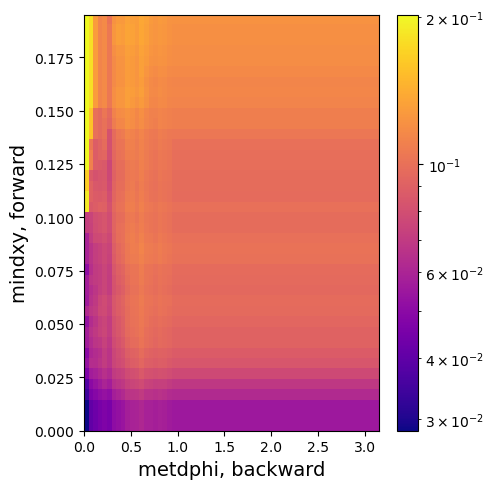

In [14]:
plot_SoverB("sig_2018_Mchi-52p5_dMchi-5p0_ctau-100",
            "sel_vtx_METdPhi_vs_mindxy",
            1j,1j,cut="cut11",forwardX=False,forwardY=True,xlabel="metdphi",ylabel="mindxy",m="",dm="",ct="",xlim=None,ylim=None)

In [17]:
h = sig['sel_vtx_METdPhi_vs_mindxy'][{'samp':'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1','cut':'cut11'}]